This line loads the necessary libraries for working with financial data and machine learning. It creates a Spark Session and adds the necessary components to build a linear regression model. Additionally, it takes a precaution to suppress any possible warnings.

In [1]:
import datetime as dt
import pandas as pd
#!pip install yfinance
import yfinance as yf

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import to_date
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

This line is related to initializing a SparkSession because a session is required to work with Spark. We are either initializing a new SparkSession with the name 'NVDA Price Prediction' or getting an existing one.

In [4]:
# Start a SparkSession
spark = SparkSession.builder.appName("NVDA Price Prediction").getOrCreate()

24/04/07 02:20:30 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


These lines load the data and create a DataFrame.
We specify 'header=True' and 'inferSchema=True' options indicating that the first row of the data file contains the header and the data types should be inferred, respectively.
Then, we convert the 'Date' column to the date type.

In [5]:
# Loading data and creating DataFrame
data = spark.read.csv("file:///home/hduser/Desktop/NVDA/NVDA_histrical_data.csv", header=True, inferSchema=True)
# Convert the 'Date' column to date type 
data = data.withColumn("Date", to_date(data["Date"]))

In [6]:
data.show(5)

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|      Date|               Open|               High|                Low|              Close|          Adj Close|  Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|1999-03-22| 0.4466150104999542|0.44791701436042786|0.42447900772094727|0.42447900772094727| 0.3893755376338959| 3667200|
|1999-03-23|0.42708298563957214|0.42708298563957214|           0.390625| 0.3984380066394806| 0.3654879927635193|16396800|
|1999-03-24|0.39583298563957214| 0.3984380066394806|0.38020798563957214|0.39583298563957214| 0.3630985617637634| 6086400|
|1999-03-25| 0.3945310115814209|0.41666701436042786|0.39322900772094727|0.40104201436042786|0.36787667870521545| 4032000|
|1999-03-26|            0.40625|             0.4375|            0.40625|0.43619799613952637|0.40012532472610474| 8827200|
+----------+------------

In [7]:
spark.createDataFrame(data.tail(5)).show()

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|2024-03-15|869.2999877929688|895.4600219726562|862.5700073242188|878.3699951171875|878.3699951171875|64019300|
|2024-03-18|903.8800048828125|924.0499877929688|870.8499755859375|884.5499877929688|884.5499877929688|66897600|
|2024-03-19|            867.0|905.4400024414062|850.0999755859375|  893.97998046875|  893.97998046875|67217100|
|2024-03-20| 897.969970703125|904.0999755859375|  882.22998046875| 903.719970703125| 903.719970703125|47906300|
|2024-03-21|            923.0|  926.47998046875|904.0499877929688|914.3499755859375|914.3499755859375|48037200|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--

In [8]:
# Discard all columns except 'Close'
df_org = data.select("Date", "Close")
# Show the first 5 lines
df_org.show(5)

+----------+-------------------+
|      Date|              Close|
+----------+-------------------+
|1999-03-22|0.42447900772094727|
|1999-03-23| 0.3984380066394806|
|1999-03-24|0.39583298563957214|
|1999-03-25|0.40104201436042786|
|1999-03-26|0.43619799613952637|
+----------+-------------------+
only showing top 5 rows



In these lines, during the data preparation stage, we select the 'Close' and 'Date' columns which will be used for machine learning. We drop all other columns because we don't need them and we want to simplify our machine learning model.

In [9]:
df = df_org

In these lines, we calculate the number of missing values for each column. We achieve this using the 'col', 'count', and 'when' functions from the 'pyspark.sql.functions' library. We use the 'show()' function to display the results.

In [10]:
from pyspark.sql.functions import col, count, when

# Her bir sütun için eksik değer sayısını hesaplama
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+-----+
|Date|Close|
+----+-----+
|   0|    0|
+----+-----+



We save the simplified dataset in CSV format so that we can easily call it later, and we use the 'header=True' option to include the header row.

In [11]:
# Save DataFrame limited to 'Close' column and 'Date' column as CSV
# df.write.csv("file:///home/hduser/Desktop/NVDA/NVDA.csv", header=True)


While there isn't a way to completely suppress warnings, you can reduce the verbosity of logs by adjusting the log level. Setting the log level of Spark to 'ERROR' will only display error messages, reducing the visibility of warnings.

In [12]:
spark.sparkContext.setLogLevel("ERROR")

# ML-Lib

## Loading the Dataset and Creating Features:
 In this step, We added lag features, commonly used in time series datasets such as financial data analysis. This allows us to see how each observation's closing price changed relative to previous observations. Additionally, we added date features to determine which day of the week each observation corresponds to. Such date features enable deeper analysis.

In [13]:
from pyspark.sql.functions import lag,col, to_date, dayofweek
from pyspark.sql.window import Window

# Add delayed attributes
for i in range(1, 6):
    df = df.withColumn(f"lag_{i}", lag(col("Close"), i).over(Window.orderBy("Date")))

# Add day of week date attributes
df = df.withColumn("DayOfWeek", dayofweek(col("Date")))

# Create a list of attributes to be used for training
input_cols = [f"lag_{i}" for i in range(1, 6)] + ['DayOfWeek']
input_cols

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'DayOfWeek']

This code block handles missing values initially that might occur as we take the closing values of previous dates as 5 different lag values. Then, it fills in missing values with the closing value of the same day. This process ensures proper filling of missing values at the beginning and contributes to the more accurate training of the model.

In [14]:
from pyspark.sql import functions as F

for i in range(1, 6):
    # 'lag' sütunlarını mevcut 'Close' değeriyle doldurun
    df = df.withColumn(f"lag_{i}", F.coalesce(df[f"lag_{i}"], df["Close"]))

In [15]:
#df.show(6)

In this code block, the dayofweek function is imported from the pyspark.sql.functions module. Then, the VectorAssembler is executed to concatenate the feature columns and create a feature vector. This vector contains the features to be used for each observation and is assigned to a new column named features. Finally, the dataset is split into training and test data. 80% of the dataset is assigned as training data while 20% is assigned as test data. This allows for the separation of data used for training the model and creating a separate test dataset for evaluating the model's accuracy.

In [16]:
from pyspark.sql.functions import dayofweek

# Run VectorAssembler
vectorAssembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df = vectorAssembler.transform(df)

# Separating the data set into training and test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


## Training the Model and Observing Coefficients:

In this code block, a linear regression model is defined and trained. Firstly, the LinearRegression class is imported from the pyspark.ml.regression module. Then, a linear regression model is created using the LinearRegression class. This model is trained with the training data, where the feature vector (featuresCol) along with the target variable (labelCol) specified as the "Close" column. After training the model, predictions are made on both the training and test sets. Finally, the coefficients and intercept value of the model are printed. These values determine the effect of each feature and the constant term of the model.

We chose the linear regression model because it is suitable for analyzing data that follows a similar trend over time, such as stock prices. Linear regression provides an ideal starting point for understanding how prices change over time and the impact of other factors on prices.

In [17]:
from pyspark.ml.regression import LinearRegression

# Define and train the model
lr = LinearRegression(featuresCol="features", labelCol="Close")
model = lr.fit(train_df)

# Make predictions on training and test sets
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Print model coefficients and interceptprint("Intercept:", model.intercept)
print("Coefficients:")
for i, coeff in enumerate(model.coefficients):
    print(f"lag_{i+1} coefficient: {coeff}")


Coefficients:
lag_1 coefficient: 0.9337373195024947
lag_2 coefficient: -0.04444383555935839
lag_3 coefficient: 0.13583450907517358
lag_4 coefficient: -0.042829205807827314
lag_5 coefficient: 0.022714581792605455
lag_6 coefficient: -0.03340973729783707


## Model Evaluation (RMSE and MSE)

RMSE (Root Mean Square Error) is a metric that measures how far the model's predictions are from the actual values, calculated as the square root of the average of the squared differences.

MSE (Mean Squared Error) is a metric that measures how far the model's predictions are from the actual values, calculated as the average of the squared differences. These metrics are commonly used to evaluate the performance of a regression model.

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define and calculate RMSE and MSE evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close")

train_rmse_MLLib = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse_MLLib = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mse_MLLib = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
test_mse_MLLib = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})

print(f"Train RMSE: {train_rmse_MLLib}, Train MSE: {train_mse_MLLib}")
print(f"Test RMSE: {test_rmse_MLLib}, Test MSE: {test_mse_MLLib}")

Train RMSE: 3.81371978892459, Train MSE: 14.544458628435018
Test RMSE: 3.0538706461634777, Test MSE: 9.326125923498937


## Making predictions for the dates from the last day of the dataset to the current date.
We calculated the total number of days and weekdays that have passed from the last day of the dataset to the present date.

In [19]:
import datetime as dt

last_row = train_df.orderBy(F.desc("Date")).first()
today_date = last_row["Date"]
#end = dt.datetime.now()
end = dt.datetime.now().date()
# Define a variable to store the number of weekdays and total days 
# Since the values for these variables will be from one day ago, we start at -1
weekdays_count = 0
total_days = 0
# Check if it is a weekday for each day by looping the date range
current_date = today_date
while current_date < end:
    total_days += 1
    # If the day is a weekday, increment the variable weekdays_count
    if current_date.weekday() < 5:  # Pazartesi (0) - Cuma (4)
        weekdays_count += 1
    # Take the next day
    current_date += dt.timedelta(days=1)

# Print the number of weekdays
print("Total number of weekdays:", weekdays_count)
print("Total number of days:", total_days)

Total number of weekdays: 12
Total number of days: 17


This code snippet creates a list of future dates, skipping weekends. It iterates over a range of total days, starting from 1 until the total days plus 2. For each day, it calculates the next day starting from today's date (today_date) and adds the number of days using timedelta(days=i). If the next day is a weekday (Monday to Friday), it appends it to the future_dates list. Finally, it returns the list of future dates excluding weekends.

In [20]:
from datetime import datetime, timedelta
# Create a list for future dates, skip weekends
future_dates = []
for i in range(1, total_days+1):
    next_day = today_date + timedelta(days=i)
    if next_day.weekday() < 5:  # 0: Monday, ..., 4: Friday
        future_dates.append(next_day)
future_dates

[datetime.date(2024, 3, 22),
 datetime.date(2024, 3, 25),
 datetime.date(2024, 3, 26),
 datetime.date(2024, 3, 27),
 datetime.date(2024, 3, 28),
 datetime.date(2024, 3, 29),
 datetime.date(2024, 4, 1),
 datetime.date(2024, 4, 2),
 datetime.date(2024, 4, 3),
 datetime.date(2024, 4, 4),
 datetime.date(2024, 4, 5)]

In [21]:
# Create new lagged attributes from the model's latest predictions and known values
last_known_values = [last_row["Close"]] + [last_row[f"lag_{i}"] for i in range(1, 5)]

In this line, we use the previously trained model to predict the closing prices for future dates. By adding our predictions to a DataFrame, we create a structured data containing the predicted closing prices and their respective dates.

In [22]:
from pyspark.sql.functions import lit, array
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import to_date, max
from datetime import datetime, timedelta

# Set the number of days you want to forecast
future_days = len(future_dates)  

# Get the latest date in the data set
last_date_row = df.select(max(to_date("Date"))).collect()
current_date = last_date_row[0][0]

# Create an empty DataFrame for future dates
future_predictions = []

# Our model uses 5 lag specifications (lag_1, lag_2, ... lag_5),
# and last_known_values contains the last known 'Close' value and 5 delay properties:
lag_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']


# Make predictions with the loop
for future_date in future_dates:
    # Create the new features vector
    new_features = last_known_values[-len(lag_features):] + [last_known_values[0]]
    new_features_vector = Vectors.dense(new_features)
    
    # Create the new data set and forecast
    df_to_predict = spark.createDataFrame([(future_date, new_features_vector)], ["Date", "features"])
    prediction = model.transform(df_to_predict)
    
    # Get the predicted value and add it to the result list
    predicted_close = prediction.select("prediction").collect()[0]["prediction"]
    future_predictions.append((future_date, predicted_close))
    
    # Update 'lag' values for the next forecast
    last_known_values = new_features[1:] + [predicted_close]

# Create the DataFrame containing the predictions
predictions_df = spark.createDataFrame(future_predictions, ["Date", "MLLib_Close"])
predictions_df.show()


+----------+-----------------+
|      Date|      MLLib_Close|
+----------+-----------------+
|2024-03-22|886.6001688734106|
|2024-03-25|865.5773379209504|
|2024-03-26|851.4134418426622|
|2024-03-27|856.2187728958244|
|2024-03-28|834.7049997172702|
|2024-03-29|821.4150077861905|
|2024-04-01|822.9755988650437|
|2024-04-02|801.0484180375386|
|2024-04-03|788.1242849790327|
|2024-04-04|786.6072965580347|
|2024-04-05|764.2738919096104|
+----------+-----------------+



In [23]:
spark.createDataFrame(df_org.tail(5)).show()

+----------+-----------------+
|      Date|            Close|
+----------+-----------------+
|2024-03-15|878.3699951171875|
|2024-03-18|884.5499877929688|
|2024-03-19|  893.97998046875|
|2024-03-20| 903.719970703125|
|2024-03-21|914.3499755859375|
+----------+-----------------+



In [24]:
import datetime as dt
import pandas as pd
#pip install yfinance
import yfinance as yf
import numpy as np

This code snippet fetches the actual closing prices of the NVDA stock from Yahoo Finance by specifying start and end dates. The downloaded data contains daily closing prices for the specified date range. Then, it creates a DataFrame containing the actual closing prices by extracting the parts of the data excluding the columns "Open", "High", "Low", "Adj Close", and "Volume".

Also the dataset I pulled from yohoo does not have the date of march 29th. this is because it is a public holiday.

In [25]:
end = dt.datetime.now()
#end = dt.datetime(2024,3,27)
start = dt.datetime(2024,3,22)
start,end

(datetime.datetime(2024, 3, 22, 0, 0),
 datetime.datetime(2024, 4, 7, 2, 20, 39, 70129))

In [26]:
df_real = yf.download("NVDA",start,end)
df_real_close = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_close

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998
2024-04-01,903.630005
2024-04-02,894.520020
2024-04-03,889.640015
2024-04-04,859.049988


To better compare my datasets and prepare them for future machine learning models, we converted a Spark DataFrame to a Pandas DataFrame.

In [27]:
# Convert Spark DataFrame to Pandas DataFrame
df_MLLib_forecast = predictions_df.toPandas()
# Assign 'Date' column as index
df_MLLib_forecast = df_MLLib_forecast.set_index('Date')
df_MLLib_forecast

,MLLib_Close
Date,
2024-03-22,886.600169
2024-03-25,865.577338
2024-03-26,851.413442
2024-03-27,856.218773
2024-03-28,834.705000
2024-03-29,821.415008
2024-04-01,822.975599
2024-04-02,801.048418
2024-04-03,788.124285


In [28]:
#!pip install plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected = True)
pd.options.plotting.backend = "plotly"

we will combine the actual closing values with all the data we predict. this way it will be easier when creating charts or making comparisons

In [29]:
# Merge via Index
# This will bring data from the same dates side by side
merged_df = df_real_close.join(df_MLLib_forecast, how='inner')
merged_df

,Close,MLLib_Close
Date,,
2024-03-22,942.890015,886.600169
2024-03-25,950.020020,865.577338
2024-03-26,925.609985,851.413442
2024-03-27,902.500000,856.218773
2024-03-28,903.559998,834.705000
2024-04-01,903.630005,822.975599
2024-04-02,894.520020,801.048418
2024-04-03,889.640015,788.124285
2024-04-04,859.049988,786.607297


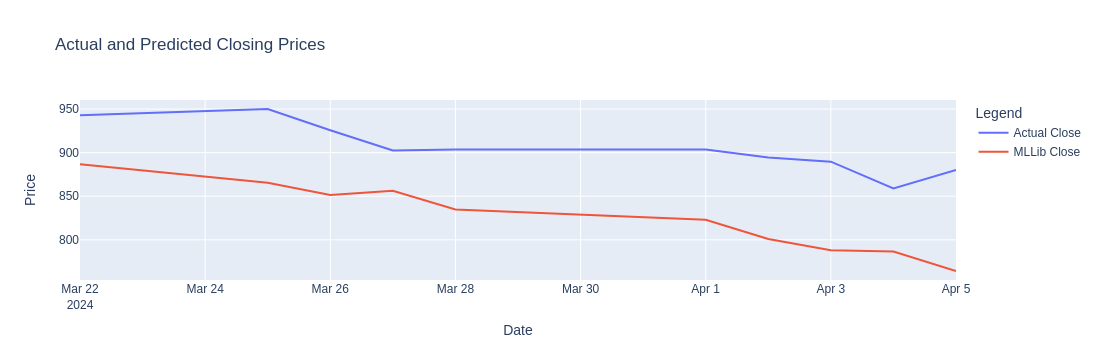

In [30]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)

trace2 = go.Scatter(
    x=merged_df.index,
    y=merged_df['MLLib_Close'],
    mode='lines',
    name='MLLib Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


MAE (Mean Absolute Error): It represents the average absolute difference between the predicted and actual values. A lower MAE indicates better model performance.

MSE (Mean Squared Error): It measures the average of the squares of the errors. A lower MSE suggests better model performance.

RMSE (Root Mean Squared Error): It is the square root of the MSE. It represents the standard deviation of the differences between the predicted and actual values. A lower RMSE indicates better model performance.

In [31]:
# Calculate error metrics
errors = merged_df['Close'] - merged_df['MLLib_Close']
mae = np.mean(np.abs(errors))
mse = np.mean(np.square(errors))
rmse = np.sqrt(mse)

print(f"MAE: {mae}") # Mean Absolute Error - MAE
print(f"MSE: {mse}") # Mean Squared Error - MSE
print(f"RMSE: {rmse}") # Root Mean Squared Error - RMSE

MAE: 79.39558494357784
MSE: 6689.372200238968
RMSE: 81.78858233420462


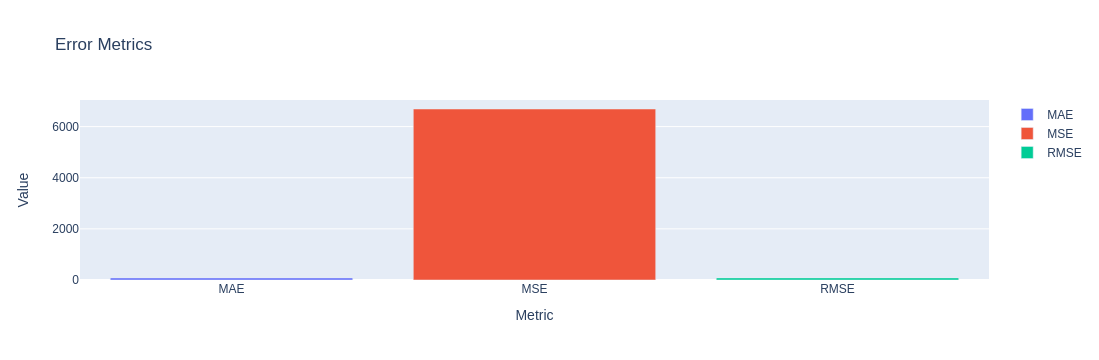

In [32]:
import plotly.graph_objs as go

hata = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae, mse, rmse]
}
# Create a bar chart and activate the legend feature
traces = []
for metric, value in zip(hata['Metrics'], hata['Values']):
    traces.append(go.Bar(x=[metric], y=[value], name=metric))

fig = go.Figure(data=traces)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Show legend
)
fig.show()

# ARIMA

  The ARIMA model is a popular choice for the analysis of financial time series because it has the capability to capture non-linear trends and seasonal fluctuations. Financial data, like closing prices, often exhibit regular patterns and trends over time, and ARIMA allows us to model these trends for future forecasting. This model is also quite effective in extracting meaningful information from noisy datasets and determining relationships between data. For this reason I chose the ARIMA model for comparison with my previous MLLib

This time I read the data using pandas rather than pyspark since we will be using ARIMA. I then converted the data in the 'Date' column to date format and assigned this column as an index so that the data was ready for time series analysis. I visualized the closing prices of the stock as a time series in the form of a line chart so that I could observe trends and fluctuations in the data.

In [33]:
df_arima = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [34]:
df_arima.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [35]:
# Convert the date column to datetime type and set it as index
df_arima["Date"] = pd.to_datetime(df_arima["Date"])
df_arima.set_index("Date", inplace=True)

# Let's show the final data set
df_arima.head()

,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [36]:
#!pip install statsmodels

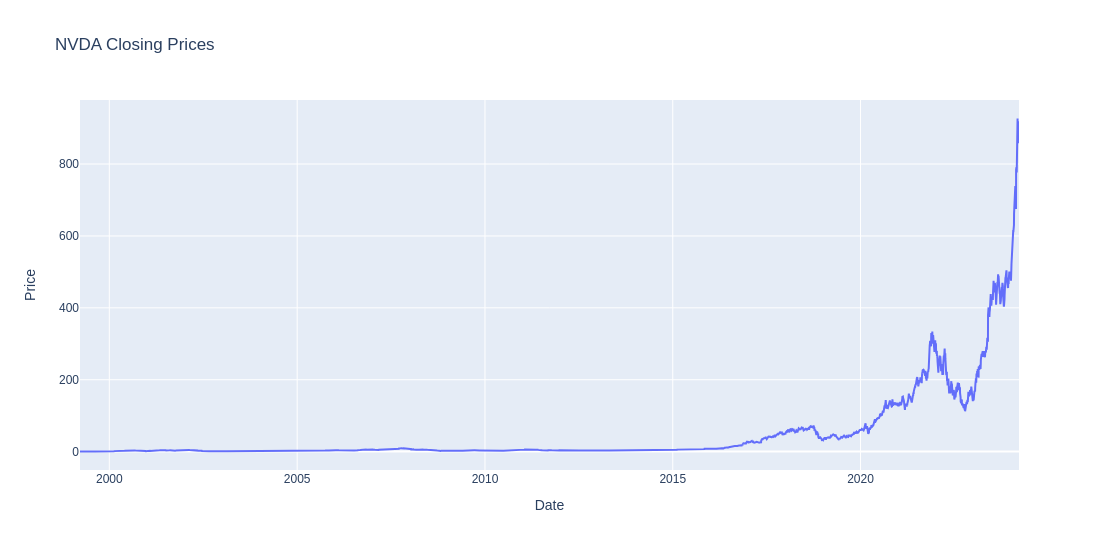

In [37]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=df_arima.index,
    y=df_arima['Close'],
    mode='lines',
    name='Closing price'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1])
fig.update_layout(
    title='NVDA Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    width = 1100, 
    height = 550
    #legend_title='Legend'
)

fig.show()


## Stationarity test

- In this code block, I first perform the Augmented Dickey-Fuller (ADF) test using the adfuller function. The ADF test tests whether the series contains a unit root, that is, whether the time series is stationary. Stationarity is one of the assumptions of time series models and determines whether the series has a constant mean and variance over time, which is necessary for models such as ARIMA to make accurate predictions.
- Outputs such as the test statistic and the p-value give an idea whether the series is stationary or not. A p-value of less than 0.05 usually indicates that the series is stationary. Here, however, the p-value is 1.0, indicating that the series is non-stationary.
- Next, we take the first difference of the closing stock prices. First differencing attempts to make the series stationary by reducing the trend and seasonality, if any. After taking the difference, we plot the difference series with the df_diff.plot() function, which provides a visual representation of the stationarity of the series.

In [38]:
# Let's test for stationarity (Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_arima["Close"])
adf_test_output = {"Test Statistic": adf_test[0], "p-value": adf_test[1], "Critical Values": adf_test[4]}
adf_test_output

{'Test Statistic': 5.155957114554979,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.43139554655334,
  '5%': -2.8620020389491527,
  '10%': -2.5670159403767285}}

In [39]:
df_diff = df_arima["Close"].diff().dropna()

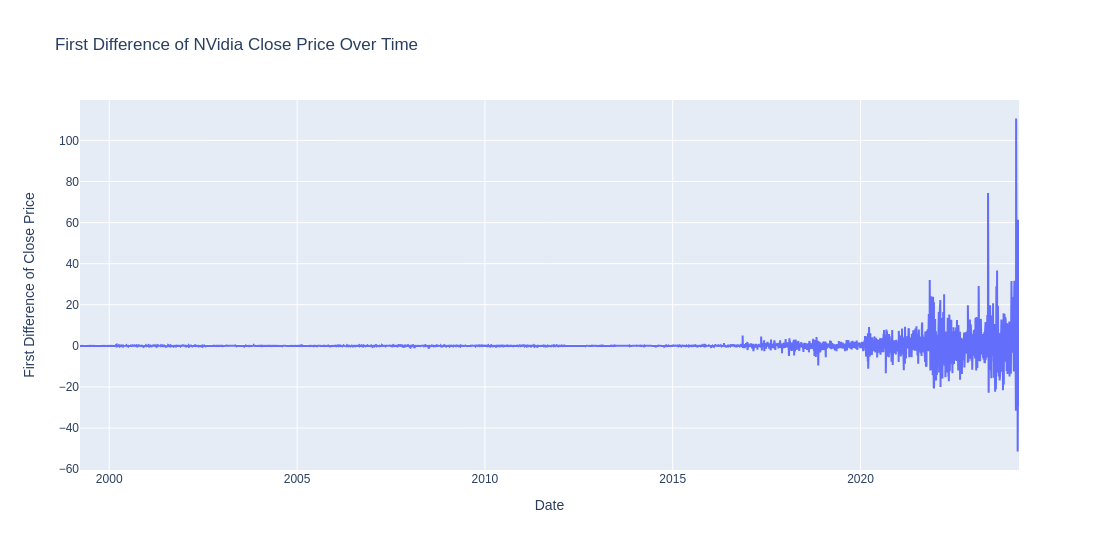

In [40]:
# Let's graph the first difference
# Create Plotly Scatter objects
trace_df_diff = go.Scatter(
    x=df_diff.index,
    y=df_diff,
    mode='lines',
    name='Closing price'
)
# Create and show the combined graph
fig = go.Figure(data=[trace_df_diff])
fig.update_layout(
    title='First Difference of NVidia Close Price Over Time',
    xaxis_title='Date',
    yaxis_title='First Difference of Close Price',
    width = 1100, 
    height = 550
    #legend_title='Legend'
)
fig.show()

After taking the first differences, I performed the ADF test again to check for stationarity of the series. I ran the adfuller function on my differenced series this time and the results included the test statistic and p-value. With the test statistic around -5.75 and the p-value below 0.05, I can now say that my series is stationary and in a suitable condition for ARIMA modeling. Stationarity means that the statistical properties of the time series data (like mean, variance, and autocorrelation) do not change over time, thereby providing a more reliable foundation for forecasting models.

In [41]:
# Let's test for stationarity again
adf_test_diff = adfuller(df_diff)
adf_test_diff_output = {"Test Statistic": adf_test_diff[0], "p-value": adf_test_diff[1], "Critical Values": adf_test_diff[4]}
adf_test_diff_output

{'Test Statistic': -5.757858629267697,
 'p-value': 5.76359951481798e-07,
 'Critical Values': {'1%': -3.431395379411139,
  '5%': -2.8620019651000943,
  '10%': -2.567015901065109}}

The ACF (Autocorrelation Function) measures the correlation of the time series data at different time lags and helps me determine the AR (Autoregressive) terms for the model. The PACF (Partial Autocorrelation Function) measures the correlation at each lag after controlling for the correlations due to the terms at all shorter lags and aids in selecting the MA (Moving Average) terms. These plots are used while determining the p, d, q parameters of the ARIMA model, where ‘p’ is the number of AR terms, ‘d’ is the number of differencing required to make the series stationary, and ‘q’ is the number of MA terms. By interpreting the ACF and PACF plots, I decided which parameters would make my model perform best.

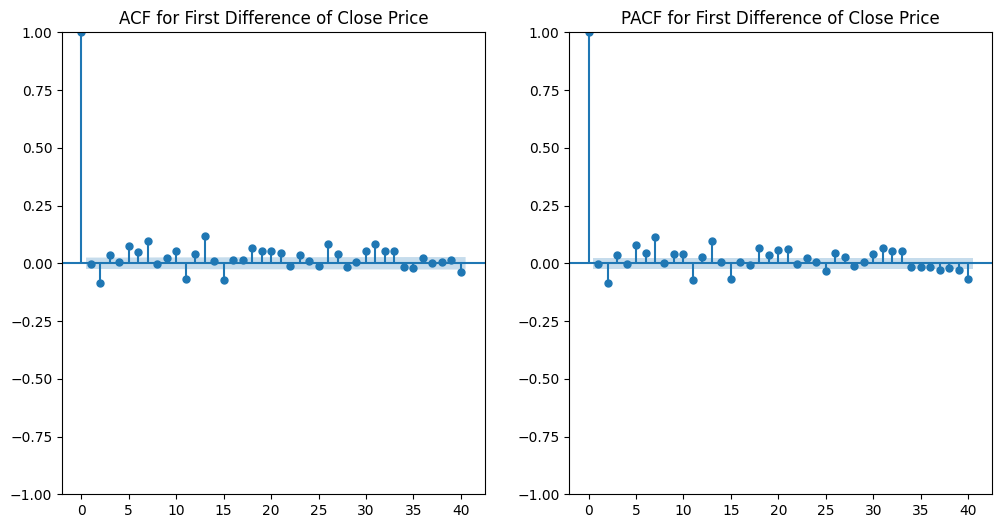

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Let's plot ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Automatic Cross Correlation Function (ACF)
plot_acf(df_diff, ax=ax1, lags=40, alpha=0.05)
ax1.set_title("ACF for First Difference of Close Price")

# Partial Automatic Cross-Correlation Function (PACF)
plot_pacf(df_diff, ax=ax2, lags=40, alpha=0.05)
ax2.set_title("PACF for First Difference of Close Price")

plt.show()


In this step, I used the ARIMA module from the statsmodels library to construct and train an ARIMA model on the stock closing prices. I set the order parameter of the model to (1, 1, 1); this indicates one AR term, one differencing operation, and one MA term, which I chose based on the information I gathered from the ACF and PACF plots. After fitting the model, I obtained a summary with model_fit.summary() and reviewed the results. The model summary includes information like the AIC and BIC, which are metrics that will help me assess how well the model fits, as well as the coefficients, standard errors, and results of other statistical tests. I use this information to understand how well the model fits the data and how reliable its forecasts might be.

In [43]:
from statsmodels.tsa.arima.model import ARIMA
df_arima = df_arima.asfreq('B')

# Building and training an ARIMA model
model = ARIMA(df_arima["Close"], order=(1, 1, 1))
model_fit = model.fit()

# Model summary
model_summary = model_fit.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6524
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17217.616
Date:                Sun, 07 Apr 2024   AIC                          34441.231
Time:                        02:20:42   BIC                          34461.581
Sample:                    03-22-1999   HQIC                         34448.268
                         - 03-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9080      0.006   -158.403      0.000      -0.919      -0.897
ma.L1          0.9537      0.005    206.723      0.000       0.945       0.963
sigma2        13.5654      0.030    446.404      0.0

To make my predictions, I used an ARIMA model with steps equal to the number of working days.
Then, I converted the predictions into a DataFrame and placed them in a column called 'ARIMA_Close'. I mapped the index of this DataFrame to dates and named the index 'Date'.

In [44]:
# Using Pandas we will calculate the number of working days and the total number of days
start_arima = df_arima.index.max()

# Let's take today's date
end_arima = pd.to_datetime("today").normalize()  # Saat bilgisi olmadan bugünün tarihi

# Let's calculate working days
business_days = pd.bdate_range(start=start_arima, end=end_arima)

# Let's initialize the number of working days and total days with -1 because we don't count the start day
weekdays_count_arima = len(business_days) -1
total_days_arima = (end_arima - start_arima).days 
weekdays_count_arima, total_days_arima

(11, 17)

In [45]:
forecast_steps = weekdays_count_arima # The next working days
# Forecasting for the next working days
forecast = model_fit.forecast(steps=forecast_steps)

# Let's get the right date range and forecasts
forecast_dates = pd.date_range(start=df_arima.index[-1], periods=forecast_steps, freq='B')
forecast_values = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Let's make sure the number of dates and forecasts are the same so there are no discrepancies
forecast_dates = forecast_dates[1:]  # İlk tarihi hariç tutuyoruz çünkü tahmin başlangıcı mevcut verinin sonrası olmalı

# We convert the results into a DataFrame
df_arima_forecast = pd.DataFrame({"ARIMA_Close": forecast_values })
df_arima_forecast.rename_axis("Date", inplace=True)
df_arima_forecast

,ARIMA_Close
Date,
2024-03-22,915.961616
2024-03-25,914.498229
2024-03-26,915.827000
2024-03-27,914.620462
2024-03-28,915.716012
2024-03-29,914.721241
2024-04-01,915.624504
2024-04-02,914.804331
2024-04-03,915.549057


we have now added ARIMA results to the data we have previously combined

In [46]:
# Merge via Index
# This will bring data from the same dates side by side
merged_df = merged_df.join(df_arima_forecast, how='inner')
merged_df

,Close,MLLib_Close,ARIMA_Close
Date,,,
2024-03-22,942.890015,886.600169,915.961616
2024-03-25,950.020020,865.577338,914.498229
2024-03-26,925.609985,851.413442,915.827000
2024-03-27,902.500000,856.218773,914.620462
2024-03-28,903.559998,834.705000,915.716012
2024-04-01,903.630005,822.975599,915.624504
2024-04-02,894.520020,801.048418,914.804331
2024-04-03,889.640015,788.124285,915.549057
2024-04-04,859.049988,786.607297,914.872838


now we have created a graph to compare this value and in this graph we can compare the actual closing values with MLLib forecasts and ARIMA forecasts.

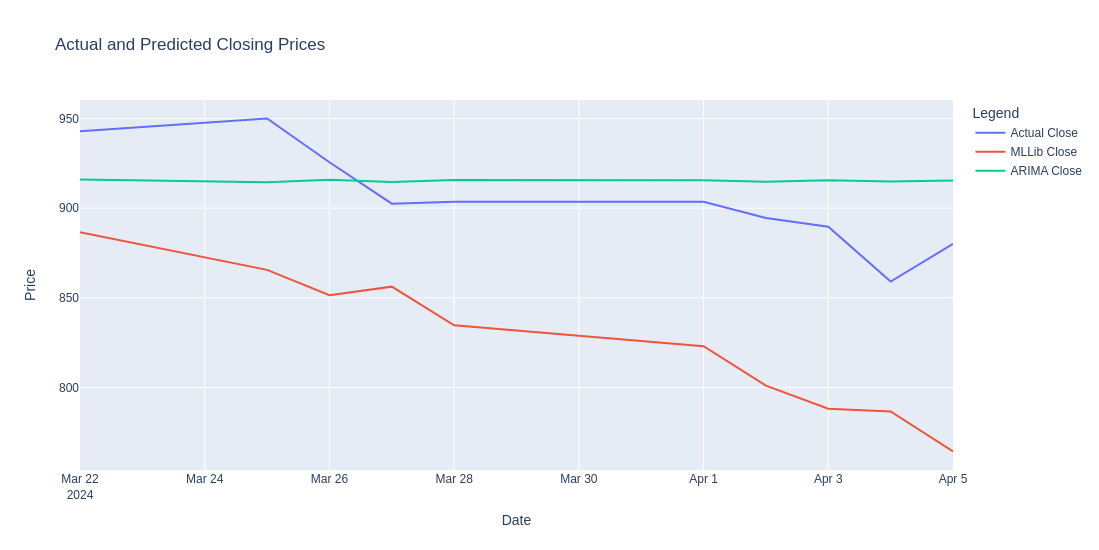

In [47]:
import plotly.graph_objs as go
# Create Plotly Scatter objects
trace_actual = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)
trace_MLLib = go.Scatter(
    x=merged_df.index,
    y=merged_df['MLLib_Close'],
    mode='lines',
    name='MLLib Close'
)
trace_ARIMA = go.Scatter(
    x=merged_df.index,
    y=merged_df['ARIMA_Close'],
    mode='lines',
    name='ARIMA Close'
)
# Create and show the combined graph
fig = go.Figure(data=[trace_actual, trace_MLLib,trace_ARIMA])
#fig = go.Figure(data=[trace_arima_actual])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    width = 1100, 
    height = 550
)
fig.show()

In [48]:
# I calculated ARIMA error metrics
errors = merged_df['Close'] - merged_df['ARIMA_Close']
mae_arima = np.mean(np.abs(errors))
mse_arima = np.mean(np.square(errors))
rmse_arima = np.sqrt(mse_arima)

print(f"MAE: {mae_arima}") # Mean Absolute Error - MAE
print(f"MSE: {mse_arima}") # Mean Squared Error - MSE
print(f"RMSE: {rmse_arima}") # Root Mean Squared Error - RMSE

MAE: 24.592718672389992
MSE: 797.3751580541746
RMSE: 28.23783203530637


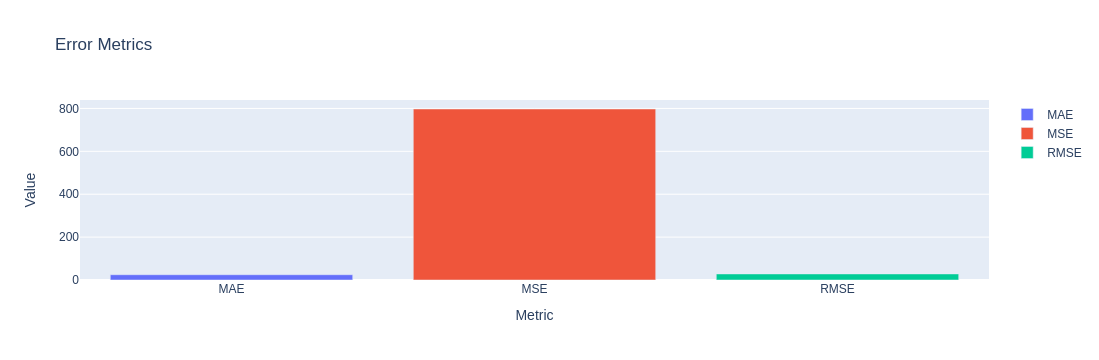

In [49]:
# Let's plot the ARIMA error metrics
hata_arima = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae_arima, mse_arima, rmse_arima]
}

# Create a go.Bar for each metric and add it to a list
traces_arima = [go.Bar(x=[metric], y=[value], name=metric) for metric, value in zip(hata_arima['Metrics'], hata_arima['Values'])]

# create the graph with go.Figure
fig = go.Figure(data=traces_arima)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Show legend
)
fig.show()

# LSTM

LSTM stands for Long Short-Term Memory (LSTM) and is a deep learning model used especially when working with sequential data, such as analyzing time series data. Unlike the ARIMA model, LSTM can learn complex and non-linear relationships and therefore may be more suitable for complex data such as financial time series. The LSTM model has the ability to capture non-linear patterns and relationships in the data. Also, LSTM can better manage missing data or noise in the data set. These features make LSTM a suitable choice for time series with complex and nonlinear relationships, such as financial data sets. In particular, financial series such as stock prices can show complex structures due to market dynamics, and deep learning models can be advantageous for modeling these structures.

In [50]:
df_LSTM = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")
# Convert the date column to datetime type and set it as index
df_LSTM["Date"] = pd.to_datetime(df_LSTM["Date"])
df_LSTM.set_index("Date", inplace=True)
# Let's show the final data set
df_LSTM.head()

,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [51]:
df_LSTM.isnull().sum()

Close    0
dtype: int64

In [52]:
import numpy as np
import pandas as pd
import joblib 
import datetime as dt

In [53]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
#from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

2024-04-07 02:20:43.235528: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 02:20:43.614380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 02:20:44.455727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Then, I used the create_dataset function to create the time series data structure necessary for my LSTM model. This function generates independent variables (X) and dependent variables (y) by using data from a certain number of previous time steps look_back from the dataset. This step is important because LSTM models are trained to predict future values by using the values from previous time steps in the data.

Then, I defined a metric to measure the performance of my model with the rmse function. RMSE (Root Mean Squared Error) is a measure of how much the model's predictions deviate from the actual values. A low RMSE value indicates that the model fits the data well and makes accurate predictions.

In [54]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Define RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

Before feeding my dataset into the LSTM model, it needs to be scaled because LSTM networks typically expect input data to be scaled between 0 and 1.  I allocated 80% of my dataset for training and the remaining 20% for testing.

We created our model using the Sequential model. We added two LSTM layers, the return_sequences=True parameter of the first layer indicates that the sequence information should be preserved for the next LSTM layer. At the end of our model, we have a Dense layer as the output layer. To compile the model we used the Adam optimizer and the mean squared error (mse) loss function.


- An epoch refers to one complete pass of the entire training dataset through the network (the model). During each epoch, the model learns by updating the weights. If too few epochs are used, the model may not learn enough and perform poorly. However, if too many epochs are used, the model may overfit to the training data, which means it would perform well on the training data but poorly on new, unseen data due to a lack of generalization.
- Batch size refers to the number of examples the model uses in one update of the model weights during training. A weight update occurs once for every batch. Smaller batch sizes often provide more stability and generalization performance, while larger batch sizes mean faster computation and shorter training time. However, very large batch sizes can lead to memory issues or the model not capturing the nuances of the training data well.

During the training process, we trained our model for 10 epochs and in mini-batches of 32 samples at a time. During training, we can see that the loss and RMSE values decrease at the end of each epoch, indicating that the performance of the model improves over time.

In [55]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_LSTM)

# Separation into training and test sets
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]

look_back = 10

In [56]:
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# For example, if there is only 1 feature (e.g. only the closing price) at each time step:
input_shape = (look_back, 1)

# If there is more than one property (e.g. both closing price and volume):
#input_shape = (look_back, 2)  # This may vary depending on the number of features used

# Create your model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics =[rmse])

# Train your model with training data
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


2024-04-07 02:20:45.563296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 02:20:45.754782: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.4250e-05 - rmse: 0.0200
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3107e-06 - rmse: 0.0210
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3741e-06 - rmse: 0.0211
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8762e-06 - rmse: 0.0212
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5822e-06 - rmse: 0.0207
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6286e-06 - rmse: 0.0213
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6912e-06 - rmse: 0.0209
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3338e-06 - rmse: 0.0214
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4762e-06 - rmse: 0.0209
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6690e-06 - rmse: 0.0211


To evaluate the performance of our model on the test data set, we calculated the RMSE (Root Mean Squared Error) metric, a measure of how much the model's predictions differ from the true values. A low RMSE value indicates that the model predictions are highly accurate.

We then made predictions on the training and test sets to calculate the RMSE values. Since the resulting predictions were scaled, we used scaler.inverse_transform to convert them back to the original scale. The expression 'np.sqrt(np.mean((y_true - y_pred)**2))' calculates the RMSE by taking the square root of the mean of the square of the differences between the predicted values and the actual values. This calculation shows how close your model is to the actual data

In [57]:
# Evaluate the model on the test data set
scores = model.evaluate(X_test, y_test)
print("RMSE: %0.3f" % scores[1])

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1052e-04 - rmse: 0.0105
RMSE: 0.024


In [58]:
# Make a prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Evaluate model performance
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 16.89 RMSE
Test Score: 245.86 RMSE


I wrote a function to predict future closing prices using my model. Initially, I gathered the last 'look_back' number of actual closing prices and scaled them, which is necessary for the model to make a prediction. I then fed my model with this scaled data to obtain a prediction and transformed this prediction back to the actual price range. Subsequently, I used these predictions as new inputs for the next prediction, ensuring that my model has the most up-to-date data for the next step. I repeated this process for the number of days I wanted to predict, which allowed me to observe how my model would forecast prices in the upcoming days. However, I am aware that these predictions may not fully reflect the real market conditions and I assess my model's performance by comparing it with real-world data.

In [59]:
def predict_next_n_days(model, normalized_data, look_back, weekdays_count_LSTM):
    predictions = []
    # Get the normalized data into the shape the model expects
    close_prices = df_LSTM["Close"].values.reshape(-1, 1)
    last_prices_scaled = scaler.transform(close_prices[-look_back:])
    # Create an array for predictions.
    predictions = []
    for i in range(weekdays_count_LSTM):
        # Make the model prediction and reverse scaling the result.
        predicted_price_normalized = model.predict(last_prices_scaled)
        predicted_price_normalized = predicted_price_normalized.reshape(look_back, 1)
        predicted_price = scaler.inverse_transform(predicted_price_normalized)[1, -1]
        
        # Add it to the prediction list.
        predictions.append(predicted_price)
        
        # Scale the last estimated price and add it to the list of scaled prices.
        last_price_scaled = np.append(last_prices_scaled, predicted_price_normalized)[-look_back:]
        last_prices_scaled = last_prices_scaled.reshape(-1, 1)
    
    return predictions

To train my LSTM model more effectively, I first prepared my training and test datasets using a specific look-back parameter. I reshaped my dataset into the appropriate 3D format so that my model could understand the input structure. I added two LSTM layers; each contains 50 cells, and I set the 'return_sequences' parameter to 'True' to pass the sequence information from the first to the second layer. I completed my model with a single Dense layer for output.

While compiling my model, I chose mean squared error as the loss function and the Adam optimizer as the optimization algorithm. I also tracked the RMSE metric to validate my model's performance. 

I made a change compared to the previous model: I converted the X_train and X_test datasets to the 3D format required by LSTM, because LSTM layers expect a tensor [number of samples, time steps, number of features] as input. I converted the training and test sets to this format: Each sample became an array containing a single feature (in this case the closing price) for a given 'look_back' time step. This reorganization of the dataset allows LSTM to better learn long-term dependencies and patterns within the time series.

- Number of Samples: This refers to the total number of independent observations or samples in the dataset.
- Time Steps: This is the number of consecutive observations within each sample. This is where our 'look_back' parameter comes into play. A value of 'look_back=10' means that the model will consider 10 time steps in each sample. This means that LSTM will use data from the previous 10 days to make a forecast for the next day.
- Number of Features: This shows the number of features (variables) we feed into our model at each time step. Since we only have a closing price, this number is 1. However, if we want to include additional data such as volume or other technical indicators, this number will increase according to the number of features used.

In [60]:
# Create training and test data sets
look_back = 20
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape data sets (LSTM to 3D format)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Create LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=100))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics =[rmse])

# Train the model
epochs=50
batch_size=16
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)  # With more epochs you can get better results

Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.1554e-05 - rmse: 0.0198
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.8427e-06 - rmse: 0.0199
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7594e-06 - rmse: 0.0202
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.0823e-06 - rmse: 0.0193
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.1929e-06 - rmse: 0.0198
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0687e-06 - rmse: 0.0195
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3013e-07 - rmse: 0.0198
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.6453e-06 - rmse: 0.0199
Epoch 9/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3889e-06 - rmse: 0.0185
Epoch 10/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.4590e-07 - rmse: 0.0200
Epoch 11/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0555e-07 - rmse: 0.0191
Epoch 12/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

In this code cell, I evaluated the performance of my model on the training and test sets and observed how accurate the predictions were based on the RMSE scores. To understand how close my predictions were to the actual data, I converted the scaled predictions back to the original price range. Then, using my model, I made predictions for future dates and created a date series corresponding to these predictions. I combined these predictions with the date information to form a new dataset, which I will use to easily analyze my predictions and compare them with real-world data.

In [61]:
# Make a prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print(f'\nlook_back= {look_back},',f'Epochs= {epochs},',f' batch_size= {batch_size}\n')
# Model performansını değerlendir
train_rmse_LSTM = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_rmse_LSTM = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_rmse_LSTM:.4f} RMSE')
print(f'Test Score: {test_rmse_LSTM:.4f} RMSE \n')

# Create date range for working days
last_date = df_LSTM.index[-1] + pd.Timedelta(days=1)
dates = pd.bdate_range(start=last_date, periods=weekdays_count, freq='B')

# Make predictions
predictions = model.predict(X_test)[-weekdays_count:] # Predictions from the end of the test set
predicted_prices = scaler.inverse_transform(predictions)

# Create DataFrame with predictions
df_LSTM_forecast = pd.DataFrame(data=predicted_prices, index=dates, columns=['LSTM_Close'])
df_LSTM_forecast.index.name = "Date"
df_LSTM_forecast

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

look_back= 20, Epochs= 50,  batch_size= 16

Train Score: 0.8413 RMSE
Test Score: 14.6584 RMSE 

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,LSTM_Close
Date,
2024-03-22,802.667358
2024-03-25,810.628479
2024-03-26,833.447754
2024-03-27,868.167664
2024-03-28,825.554382
2024-03-29,804.372131
2024-04-01,855.387756
2024-04-02,852.718628
2024-04-03,826.799683


In [62]:
# Merge via Index
# This will bring data from the same dates side by side
# If you want to run this cell a second time, you need to remove the added line first.
# So remove bottom line from the comment on the second and subsequent runs.
#merged_df=merged_df.drop('LSTM_Close',axis=1) 
merged_df = merged_df.join(df_LSTM_forecast, how='inner')
merged_df

,Close,MLLib_Close,ARIMA_Close,LSTM_Close
Date,,,,
2024-03-22,942.890015,886.600169,915.961616,802.667358
2024-03-25,950.020020,865.577338,914.498229,810.628479
2024-03-26,925.609985,851.413442,915.827000,833.447754
2024-03-27,902.500000,856.218773,914.620462,868.167664
2024-03-28,903.559998,834.705000,915.716012,825.554382
2024-04-01,903.630005,822.975599,915.624504,855.387756
2024-04-02,894.520020,801.048418,914.804331,852.718628
2024-04-03,889.640015,788.124285,915.549057,826.799683
2024-04-04,859.049988,786.607297,914.872838,822.921814


In the final step of my code, I created a graph comparing the predictions made by my three different machine learning models - ARIMA, MLlib, and LSTM - with the actual closing prices. Using the Plotly library, I displayed the predictions of each model along with the actual values on the same graph. This visualization allows me to directly compare the performance of each model, helping me understand which one best represents my time series data.

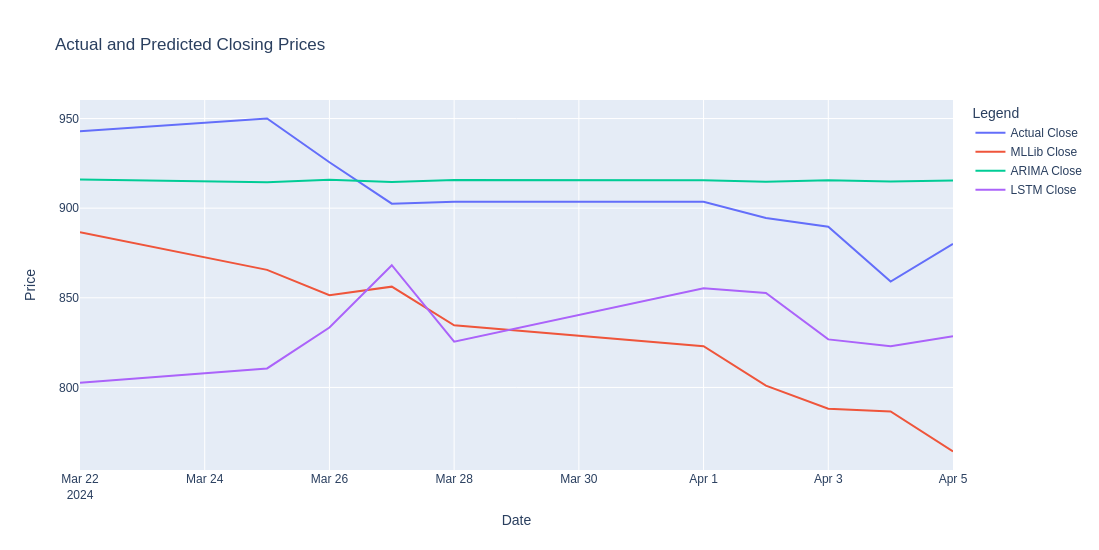

In [63]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace_actual = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)
trace_MLLib = go.Scatter(
    x=merged_df.index,
    y=merged_df['MLLib_Close'],
    mode='lines',
    name='MLLib Close'
)
trace_ARIMA = go.Scatter(
    x=merged_df.index,
    y=merged_df['ARIMA_Close'],
    mode='lines',
    name='ARIMA Close'
)
trace_LSTM = go.Scatter(
    x=merged_df.index,
    y=merged_df['LSTM_Close'],
    mode='lines',
    name='LSTM Close'
)
# Create and show the combined graph
fig = go.Figure(data=[trace_actual, trace_MLLib,trace_ARIMA,trace_LSTM])
#fig = go.Figure(data=[trace_arima_actual])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    width = 1100, 
    height = 550
)

fig.show()


Comparing the predictions of the three different models shown in the chart (ARIMA, MLlib and LSTM) for the closing prices, I can see that each model matches the actual values to different degrees. The ARIMA model follows a certain trend and seems to capture the general course of prices, but it shows less volatility compared to the other two models. The MLlib model, on the other hand, seems to capture volatility well, with a closer match to actual prices. I can see that my LSTM model draws trends similar to the actual prices at certain points, but in general it deviates from the expected price trend. However, all three models show deviations from actual closing prices, demonstrating the limits of deep learning and statistical methods for modeling complexity and unpredictability, especially in financial markets.

To improve the performance of my models, I may use a more extensive parameter optimization for my ARIMA model and I may not implement the SARIMA model to better capture seasonal effects in my dataset. When using MLlib, I can improve my model's ability to recognize market patterns by adding extra features such as financial indicators and testing different algorithms. In my LSTM model, I can increase the number of layers and neuron density to increase the learning capacity of the model and the depth of the network, while avoiding overfitting with regularization techniques. Overall, I can train on a larger historical dataset and build an ensemble model that combines the strengths of different models to maximize the predictive power of each model.